## Definitions

In [ ]:
# writing into excel library - uncomment the following line if needed
# %pip install openpyxl

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main import simulate_apartment_stock, generate_interventions, simulate_social_housing, calculate_costs
from analysis import * 
import copy

idx = pd.IndexSlice

years = np.arange(15)

# Model systému podpory v bydlení
## Cíle

* Zhodnotit přínosy a náklady zavedení systému podpory v bydlení
* Srovnat úspěšnost při řešení bytové nouze
* Představit základní logiku zákona

- [Ospravedlnění parametrů zde](https://mmrcz.sharepoint.com/:x:/r/sites/MMR-Zkonopodpoevbydlen/_layouts/15/guestaccess.aspx?share=EUy9k9Fw9JRLulyihYTMte8BSMkRlmAFsrVMBXySWvKGGg)

## Shrnutí modelu
- System dynamics model - domácnosti dostávají intervence směřující k řešení bytové nouze
- 2 typy domácností:
    - `High-risk` 
    - `Low risk`
- Každý rok se do bytové nouze dostanou další domácnosti. Zároveň ale do systému přijdou nové byty pro umístění 
- 2 typy intervencí:
- TODO lépe popsat buraucrat-centric interventions
    - *Měkké intervence* - dostane jí fixní podíl lidí čekajících ve frontě 
        - `self_help` - svépomoc bez asistence systému
        - `consulting` - Poradenství v síti KMB
        - `mop_payment` - dávka mimořádné okamžité pomoci - předpokládáme souběžné poradenství
    - *Bytové intervence* - pokud jsou k dispozici byty dané kategorie i zájemci o ně, budou přiděleny
        - `guaranteed` - Garanatované bydlení - soukromé byty se státními garancemi
        - `municipal` - obecní byty se sociálním zaměřením
- Domácnosti mění status:
    - `queue` - *Fronta* - Domácnosti v bytové nouzi čekající na pomoci
    - *Probíhající intervence* - označeno podle intervence výše
    - *Ukončená intervence* - outside, také rozlišeno dle intervence
- Vypořádání - tedy samotný modelling
    - Intervenci dostanou pouze lidé "ve frontě" 
    - Po konci intervence (která v případě bytů trvá několik let) se určitá část vrací zpátky do fronty tzv. *relapses*
    - Pokud relapsne `low risk` domácnost, přesune se do `high risk`
- Simulace probíhá 15 let
- Po vypořádání proběhne **vyúčtování**
    - Při vyúčtování se přilepí cenovky na jednotlivé intervence.
    - Druhy nákladů:
        - *Intervence - vstupní*
        - *Intervence - provozní*
        - *Systém - jednorázový*
        - *Systém - provozní*
        - *Náklady bytové nouze* - aplikuje se pro domácnosti ve frontě

## Poptávka - rozsah bytové nouze
* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje `low-risk` domácnosti do `guaranteed` bytů a `high-risk` domácnosti do `municipal` bytů 
* Oba druhy domácností mají v čase lineární trend

### Dnešní stav bytové nouze
* Celkově je 67 500 domácností v bytové nouzi - z toho 70 % domácností jsou  `high risk` domácnosti a  30 % `low risk` domácnosti

### Budoucí vývoj bytové nouze
* Předpokládáme každoroční přísun dalších 9 000 domácností - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti

In [2]:
current_level = 67000
high_current = .7
high_yearly = .35
household_size = 2.28
yearly_growth = 9100 

hhs_inflow = pd.Series({
    ('low','current_level'): (1 - high_current) * current_level,
    ('low','yearly_growth'): (1 - high_yearly) * yearly_growth,
    ('high','current_level'): high_current * current_level,
    ('high','yearly_growth'): high_yearly * yearly_growth,
}).unstack()
hhs_inflow

,current_level,yearly_growth
high,46900.0,3185.0
low,20100.0,5915.0


## Nabídka bytů

* Počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. 
* Nastavení modelu vede k (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 2000 soukromých a pomalu rostoucích cca 700 -750 městských bytů v systému ročně.
* TODO zmínit, že frikce na bytech vstupuje spíše skrze nabízené byty a není třeba snižovat počet využívaných bytů

### Garantované byty
* Nabídka garantovaných bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `guaranteed_yearly_apartments`.

### Obecní byty
* Již dnes existuje cca 160 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 0,4% (varianta 1) či 0,2 % (varianta 0) uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - předpokládáme 300 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému vstoupila výrazně větší část - 25 % ve variantě 1 a 10 % ve variantě 1 - `municipal_new_availability_rate`

In [3]:
startup_coefficients_v1 = pd.Series({
    (0,'consulting'):0.5,
    (1,'consulting'):0.75,
    (2,'consulting'):1.0,
    (0,'mop_payment'):0.5,
    (1,'mop_payment'):0.75,
    (2,'mop_payment'):1.0,
    (0,'guaranteed'):1/2,
    (1,'guaranteed'):3/4,
    (2,'guaranteed'):1.0,
    (0,'municipal'):1/2,
    (1,'municipal'):3/4,
    (2,'municipal'):1.0,    
}).unstack()
startup_coefficients_v1

,consulting,guaranteed,mop_payment,municipal
0,0.50,0.50,0.50,0.50
1,0.75,0.75,0.75,0.75
2,1.00,1.00,1.00,1.00


In [4]:
startup_coefficients_v0 = startup_coefficients_v1.copy()
startup_coefficients_v0.loc[:,:] = 1

In [5]:
municipal_apartments_today = 161100
municipal_yearly_new_apartments = 2000
simulate_apartment_stock(
        guaranteed_yearly_apartments=2000,
        municipal_apartments_today=municipal_apartments_today,
        municipal_yearly_new_apartments=municipal_yearly_new_apartments,
        municipal_existing_availability_rate=0.004,
        municipal_new_availability_rate=0.25,
        startup_coefficients=startup_coefficients_v1[['guaranteed','municipal']],
        years=years
    )

,guaranteed,municipal
0,1000,568
1,2500,1420
2,4500,2564
3,6500,3717
4,8500,4877
5,10500,6046
6,12500,7222
7,14500,8406
8,16500,9599
9,18500,10799


## Intervence a průchod domácnosti systémem

V každém roce proběhnou operace v následujícm sledu: 


1. Určení velikosti fronty (započítání relapses z minulého roku)
2. Měkké intervence (vždy podíl zbývajících domácností daného typu na frontě)
    1. `self_help` - některé domácnosti si zvládnou pomoci samy a dostanou se ven z BN
    2. `consulting` - další část domácností přijde pro poradenství na KMB a díky tomu se zvládnou dostat ven z BN
    3. `mop_payment` - další část domácností po konzultaci na KMB dostane vyplacenou dávku MOP
3. Bytové intervence (vždy porovnání počtu domácností daného typu ve frontě s počtem dostupných bytů)
    1. `Low risk` domácnosti do `guaranteed` bytů
    2. `High risk` domácnosti do `municipal` bytů
    3. `High risk` domácnosti do `guaranteed` bytů
    4. `Low risk` domácnosti do `municipal` bytů 

 Je třeba si uvědomit, že uvedené podíly se aplikují postupně a tedy postupně ubývá základ vůči kterému se podíly aplikují

 ### Intervenční podíly pro měkké intervence
 #### Varianta 0

In [6]:
intervention_shares_v0 = pd.Series({
    ('low','self_help'):.4, #
    ('low','consulting'):.0,
    ('low','mop_payment'):.02,
    ('high','self_help'):.15,
    ('high','consulting'):.0,
    ('high','mop_payment'):.02
}).unstack()

#### Varianta 1 

In [7]:
intervention_shares_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.1,
    ('low','mop_payment'):.2,
    ('high','self_help'):.1,
    ('high','consulting'):.05,
    ('high','mop_payment'):.1
}).unstack()

### Délka intervence

* Každá intervence má jinou dobu trvání
* Zatímco měkké intervence jsou jednorázové a z pohledu modelu trvají jeden rok, bydlení trvá déle

In [8]:
years_of_support = pd.Series({
    'municipal':3, 
    'guaranteed':2,
    'self_help':1,
    'mop_payment':1,
    'consulting':1
})
years_of_support

municipal      3
guaranteed     2
self_help      1
mop_payment    1
consulting     1
dtype: int64

### Relaps - neúspěšné intervence

* část domácností, se i přes to, že dostanou intervenci, se po čase zase vrátí do problémů
* Tomu model říká "relaps" - po konci intervenci domácnost neopouští systém, ale vrací se zpátky do fronty
* Tabulka níže ukazuje, jaká část domácností, které dostaly danou intervenci se po konci intervence vrací zpět do systému

In [9]:
relapse_rates_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.2,
    ('low','mop_payment'):.1,
    ('low','guaranteed'):.05,
    ('low','municipal'):.05,
    ('high','self_help'):.6,
    ('high','consulting'):.5,
    ('high','mop_payment'):.3,
    ('high','guaranteed'):.3,
    ('high','municipal'):.3
}).unstack()

relapse_rates_v1

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.30,0.3,0.30,0.6
low,0.2,0.05,0.1,0.05,0.2


Vyšší relapse rates reflektují nedostupnost sociální péče (TODO není empirická literature?)

In [10]:
relapse_rates_v0 =  relapse_rates_v1.copy()
relapse_rates_v0.mop_payment = relapse_rates_v0.mop_payment * 1.5
relapse_rates_v0.loc['high',['guaranteed','municipal']] = 0.4
relapse_rates_v0.loc['low',['guaranteed','municipal']] = 0.1
relapse_rates_v0

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.4,0.45,0.4,0.6
low,0.2,0.1,0.15,0.1,0.2


In [11]:
relapse_rates_v3 =  relapse_rates_v0.copy()
relapse_rates_v3.loc['high','guaranteed'] = 0.45
relapse_rates_v3.loc['low','guaranteed'] = 0.2
relapse_rates_v3.loc['high','municipal'] = 0.5
relapse_rates_v3.loc['low','municipal'] = 0.15

### Použití sociální asistence
* Sociální služby nejsou přímo modelovány, ale jsou přidělovány v určitém podílu a s měnící se délkou trvání
* Podíl intervenovaných, kteří zároveň s intervencí dostanou sociální asistenci a délku jejího trvání

#### Varianta 0

In [12]:
social_assistences_v0 = pd.Series({
    ('mop_payment','share'): .0,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .0,
    ('guaranteed','years'): 2,
    ('municipal','share'): .7,
    ('municipal','years'): 1,
}).unstack()

social_assistences_v0

,share,years
guaranteed,0.0,2.0
mop_payment,0.0,1.0
municipal,0.7,1.0


#### Varianta 1 

In [13]:
social_assistences_v1 = pd.Series({
    ('mop_payment','share'): .25,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .85,
    ('guaranteed','years'): 2,
    ('municipal','share'): .85,
    ('municipal','years'): 2,
}).unstack()

social_assistences_v1

,share,years
guaranteed,0.85,2.0
mop_payment,0.25,1.0
municipal,0.85,2.0


### Náklady intervencí

* Rozlišujeme tři druhy nákladů:
    * **Jednorázové** - Náklady, které je potřeba zadat pouze jednou - napříkald vývoj IT systému
    * **Fixní** - náklady existence systému sociálního bydlení, zcela nezávislé na výkonu - např. provoz IT systému.
    * **Vstupní** - náklady provedení intervence - například sehnání bytu do systému či vyplacení MOP
    * **Průběžné/Roční** - náklady probíhající intervence - náklady bytu


In [14]:
discount_rate = 0.04 # Impact assessment guidelines European Commission https://ec.europa.eu/smart-regulation/impact/commission_guidelines/docs/131210_cba_study_sg_final.pdf
intervention_costs_v1 = pd.Series({
    ('entry','self_help'): 0,
    ('entry','mop_payment'): 35126,
    ('entry','guaranteed'): 15333, #16000 # Nezahrnuje poradenství - to je vyjádřeno fixní roční částkou
    ('entry','municipal'): 0, # Nezahrnuje poradenství - to je vyjádřeno fixní roční částkou
    ('entry', 'social_assistance'): 0,
    ('yearly','self_help'): 0,
    ('yearly','mop_payment'): 0,
    ('yearly','guaranteed'): 48990,
    ('yearly','municipal'): 52616,
    ('yearly','social_assistance'): 88976,#83200,
    # 19 % inflation rate between 2020 and 2022 by CZSO; CNB Winter prediction 10.8 % (2023) and 2.1 % (2024); 
    ('yearly','queue_budget'): 1.19 * 1.108 * household_size * 20303, #47915, # https://drive.google.com/drive/u/0/folders/1AB-eICOTy3LndCi75t68i2aCKKgxXlrd p.47
    ('yearly','queue_social'): 146712,
    ('one_off','IT_system'): 60000000,#20000000,
    ('yearly','IT_system'): 20000000,#2000000,
    ('yearly','regional_administration'): 65438210,#62325941, 
    ('yearly','consulting'): 483074298,
    ('one_off','consulting'): 406901511 - 483074298# Consulting costs less in the first year. Adjustment done via one_off component. NEgative number is a discount on the total price. 
}).unstack()
intervention_costs_v1.T

,entry,one_off,yearly
IT_system,NaN,60000000.0,2.000000e+07
consulting,NaN,-76172787.0,4.830743e+08
guaranteed,15333.0,NaN,4.899000e+04
mop_payment,35126.0,NaN,0.000000e+00
municipal,0.0,NaN,5.261600e+04
queue_budget,NaN,NaN,6.103540e+04
queue_social,NaN,NaN,1.467120e+05
regional_administration,NaN,NaN,6.543821e+07
self_help,0.0,NaN,0.000000e+00
social_assistance,0.0,NaN,8.897600e+04


In [15]:
intervention_costs_v0 = intervention_costs_v1.copy()
intervention_costs_v0.loc ['yearly','IT_system'] = 0
intervention_costs_v0.loc ['yearly','regional_administration'] = 0
intervention_costs_v0.loc ['yearly','consulting'] = 0
intervention_costs_v0.loc ['one_off','consulting'] = 0
intervention_costs_v0.loc ['yearly','municipal'] = 0 
intervention_costs_v0.loc ['one_off','IT_system'] = 0

#### MOP jako součást zabydlení
Podíl intervencí typu zabydlení, které jsou doprovázeny dávkou MOP v průměrné výši

In [16]:
mop_housing_share_v0 = pd.Series({
    ('guaranteed','high'):.0,
    ('guaranteed','low'):.0,
    ('municipal','high'):.0,
    ('municipal','low'):.0,
}).unstack()

mop_housing_share_v1 = pd.Series({
    ('guaranteed','high'):1,
    ('guaranteed','low'):.25,
    ('municipal','high'):.5,
    ('municipal','low'):.0,
}).unstack()
mop_housing_share_v1


,high,low
guaranteed,1.0,0.25
municipal,0.5,0.00


## Balíčky parametrů specifikujících varianty

### Varianta 0: Bez zákona

In [17]:
INPUT_0 = {
    'title': '0: Bez zákona',
    'years':years,
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs_v0,
    'guaranteed_yearly_apartments':0, 
    'municipal_apartments_today': municipal_apartments_today,
    'municipal_yearly_new_apartments': municipal_yearly_new_apartments,
    'municipal_existing_availability_rate': .002,
    'municipal_new_availability_rate': .1, 
    'relapse_rates':relapse_rates_v0,
    'intervention_shares':intervention_shares_v0,
    'hhs_inflow':hhs_inflow,
    'social_assistences':social_assistences_v0,
    'mop_housing_share':mop_housing_share_v0,
    'discount_rate':discount_rate,
    'low_to_high_risk_share':0.5,
    'before_start_intervention_shares': intervention_shares_v0.sum(axis=1),
    'startup_coefficients':startup_coefficients_v0
}
OUTPUT_0 = simulate_social_housing(**INPUT_0)
OUTPUT_0.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 1A: Mix opatření (konzervativní)

In [18]:
INPUT_1A = copy.deepcopy(INPUT_0)
INPUT_1A['title'] = '1A: Mix opatření'
INPUT_1A['intervention_costs'] = intervention_costs_v1
INPUT_1A['guaranteed_yearly_apartments'] = 2000
INPUT_1A['municipal_existing_availability_rate'] = .004
INPUT_1A['municipal_new_availability_rate'] = .25
INPUT_1A['relapse_rates'] = relapse_rates_v1
INPUT_1A['intervention_shares'] = intervention_shares_v1
INPUT_1A['social_assistences'] = social_assistences_v1
INPUT_1A['startup_coefficients'] = startup_coefficients_v1
INPUT_1A['mop_housing_share'] = mop_housing_share_v1

OUTPUT_1A = simulate_social_housing(**INPUT_1A)
OUTPUT_1A.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 1B: Mix opatření (optimistická)

In [19]:
INPUT_1B = copy.deepcopy(INPUT_1A)
INPUT_1B['title'] = '1B: Mix opatření - 2x více bytů'
INPUT_1B['guaranteed_yearly_apartments'] = 4000
INPUT_1B['municipal_existing_availability_rate'] = .008

OUTPUT_1B = simulate_social_housing(**INPUT_1B)
OUTPUT_1B.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 2: Pouze měkká opatření

In [20]:
INPUT_2 = copy.deepcopy(INPUT_1A)
INPUT_2['title'] = '2: Pouze poradenství a sociální služby'

INPUT_2['guaranteed_yearly_apartments'] = INPUT_0['guaranteed_yearly_apartments']
INPUT_2['municipal_existing_availability_rate'] = INPUT_0['municipal_existing_availability_rate']
INPUT_2['municipal_new_availability_rate'] = INPUT_0['municipal_new_availability_rate']
INPUT_2['intervention_costs'].loc['yearly','municipal'] = 0

INPUT_2['social_assistences'].loc['municipal','share'] = 0.5
INPUT_2['social_assistences'].loc['guaranteed','share'] = 0.5

OUTPUT_2 = simulate_social_housing(**INPUT_2)
OUTPUT_2.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 3: Pouze bydlení

In [21]:
INPUT_3 = copy.deepcopy(INPUT_1A)
INPUT_3['title'] = '3: Pouze bydlení'

#INPUT_3['guaranteed_yearly_apartments'] = INPUT_3['guaranteed_yearly_apartments'] * 0.5

INPUT_3['relapse_rates'] = relapse_rates_v3
INPUT_3['intervention_shares'] = intervention_shares_v0
INPUT_3['intervention_costs'] = intervention_costs_v0
INPUT_3['social_assistences'] = social_assistences_v0

INPUT_3['intervention_costs'].loc['yearly','municipal'] = INPUT_1A['intervention_costs'].loc['yearly','municipal']
INPUT_3['intervention_costs'].loc['yearly','guaranteed'] = INPUT_1A['intervention_costs'].loc['yearly','guaranteed']
INPUT_3['intervention_costs'].loc['entry','municipal'] = INPUT_1A['intervention_costs'].loc['entry','municipal']
INPUT_3['intervention_costs'].loc['entry','guaranteed'] = INPUT_1A['intervention_costs'].loc['entry','guaranteed']

INPUT_2['social_assistences'].loc['municipal','share'] = 0.5
INPUT_2['social_assistences'].loc['guaranteed','share'] = 0.25

OUTPUT_3 = simulate_social_housing(**INPUT_3)
OUTPUT_3.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

In [22]:
output_variants = [OUTPUT_0, OUTPUT_1A, OUTPUT_1B, OUTPUT_2, OUTPUT_3]

### Pro podrobnější zkoumání lze exportovat data z jednotlivých simulací do XLSX

In [23]:
save_tables_to_excel(
    output_variants,
    'hlavni_varianty.xlsx'
)

## Vyhodnocení variant
### Počet domácností v BN

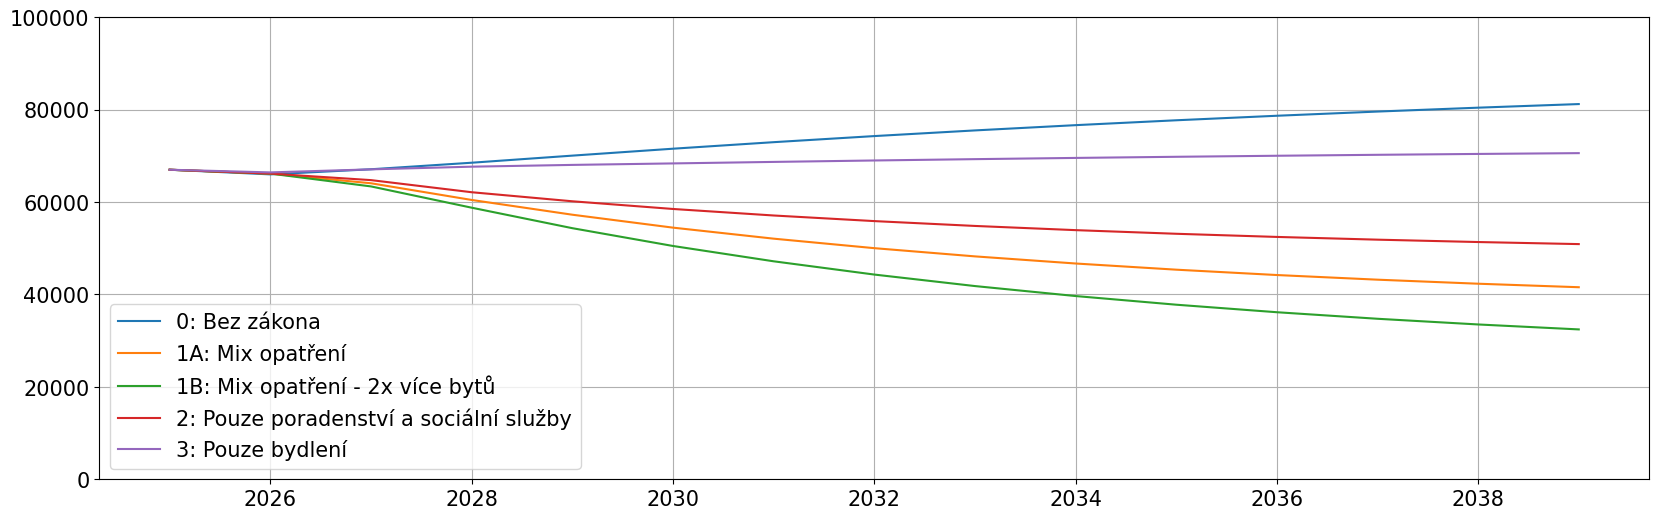

In [24]:
plot_hhs_in_emergency(output_variants,title='');

#### Celkový počet domácností v BN jako podíl vůči prvnímu roku (v textu RIA)

<Axes: xlabel='rok'>

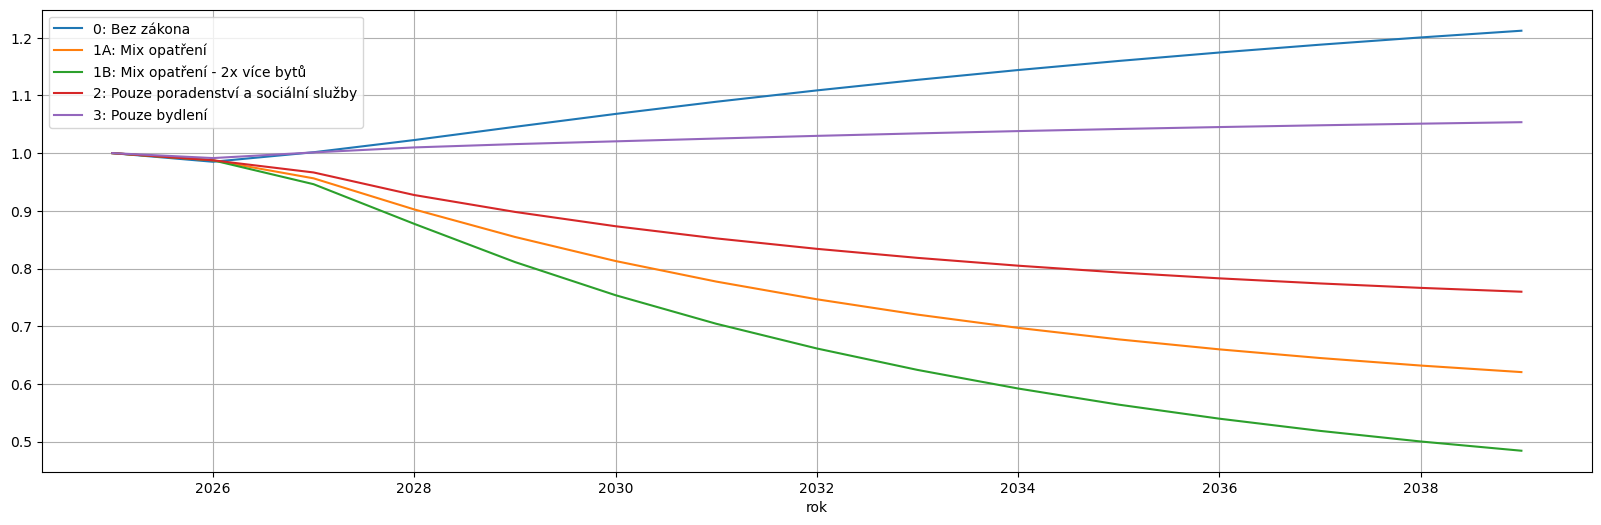

In [25]:
x = pd.DataFrame({variant['title']:variant['hhs'][['guaranteed','municipal','mop_payment','self_help','consulting','queue']].sum(axis=1) for variant in output_variants})
(x/x.iloc[0]).plot(figsize=(20,6),grid=True)

### Náklady variant

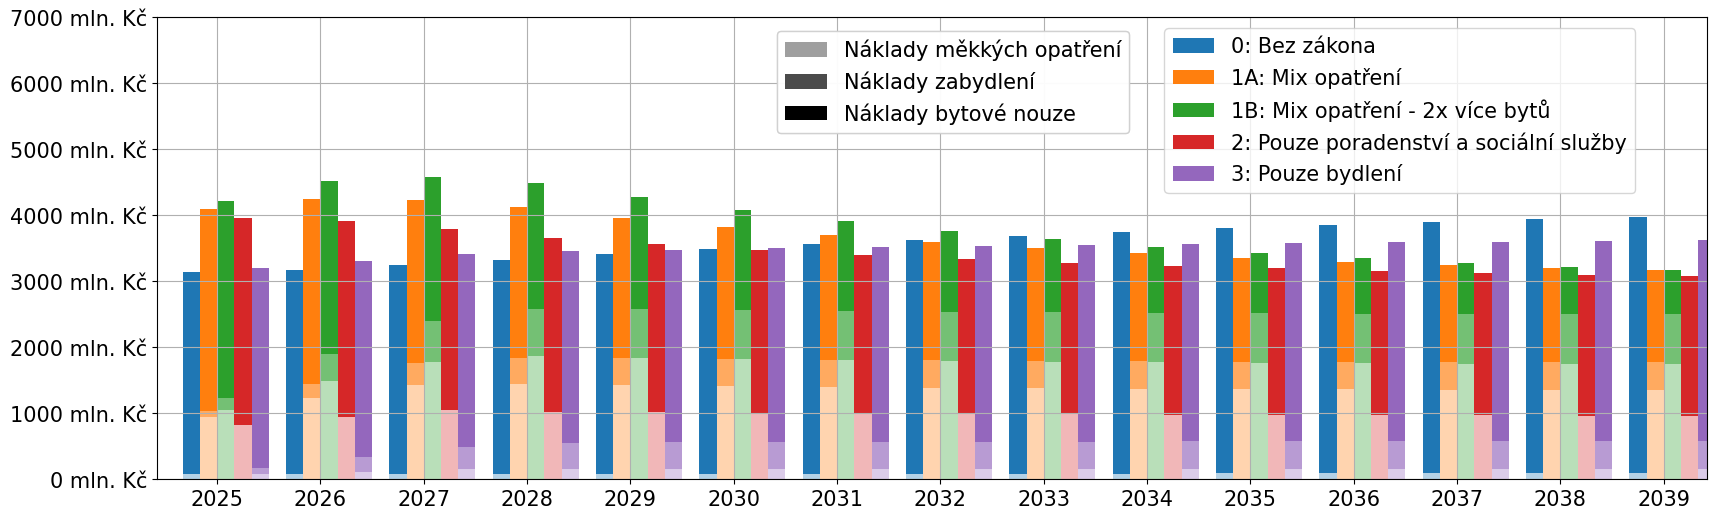

In [26]:
plot_costs_summary(
    output_variants,
    title='',key='costs'
);

#### Tabulka Vyhodnocení variant po 15 letech (NPV a počet domácností v BN)

In [32]:
npv = pd.Series({variant['title']:variant['costs_discounted'].drop('queue_social',axis=1).sum().sum() for variant in output_variants})

hhs_last_year = pd.Series({variant['title']:variant['hhs'][['guaranteed','municipal','mop_payment','self_help','consulting','queue']].sum(axis=1).iloc[-1] for variant in output_variants})
pd.DataFrame({
    'Čistá současná hodnota nákladů na variantu (za 15 let)':npv.apply(lambda x: f"{(x/1000000000):.1f} mld. Kč").str.replace('.',','),
    'Rozdíl ČSH vůči V0 (za 15 let)': (npv - npv.loc['0: Bez zákona']).apply(lambda x: f"{(x/1000000000):.1f} mld. Kč").str.replace('.',','),
    'Počet domácností v bytové nouzi po 15 letech':hhs_last_year.apply(lambda x: f"{x:.0f}").str.replace('.',',')
})

,Čistá současná hodnota nákladů na variantu (za 15 let),Rozdíl ČSH vůči V0 (za 15 let),Počet domácností v bytové nouzi po 15 letech
0: Bez zákona,"41,0 mld, Kč","0,0 mld, Kč",81214
1A: Mix opatření,"43,1 mld, Kč","2,1 mld, Kč",41570
1B: Mix opatření - 2x více bytů,"45,2 mld, Kč","4,2 mld, Kč",32439
2: Pouze poradenství a sociální služby,"40,1 mld, Kč","-0,9 mld, Kč",50905
3: Pouze bydlení,"40,3 mld, Kč","-0,7 mld, Kč",70592


#### Graf: Počet intervencí ve variantě 1A

<Axes: xlabel='rok'>

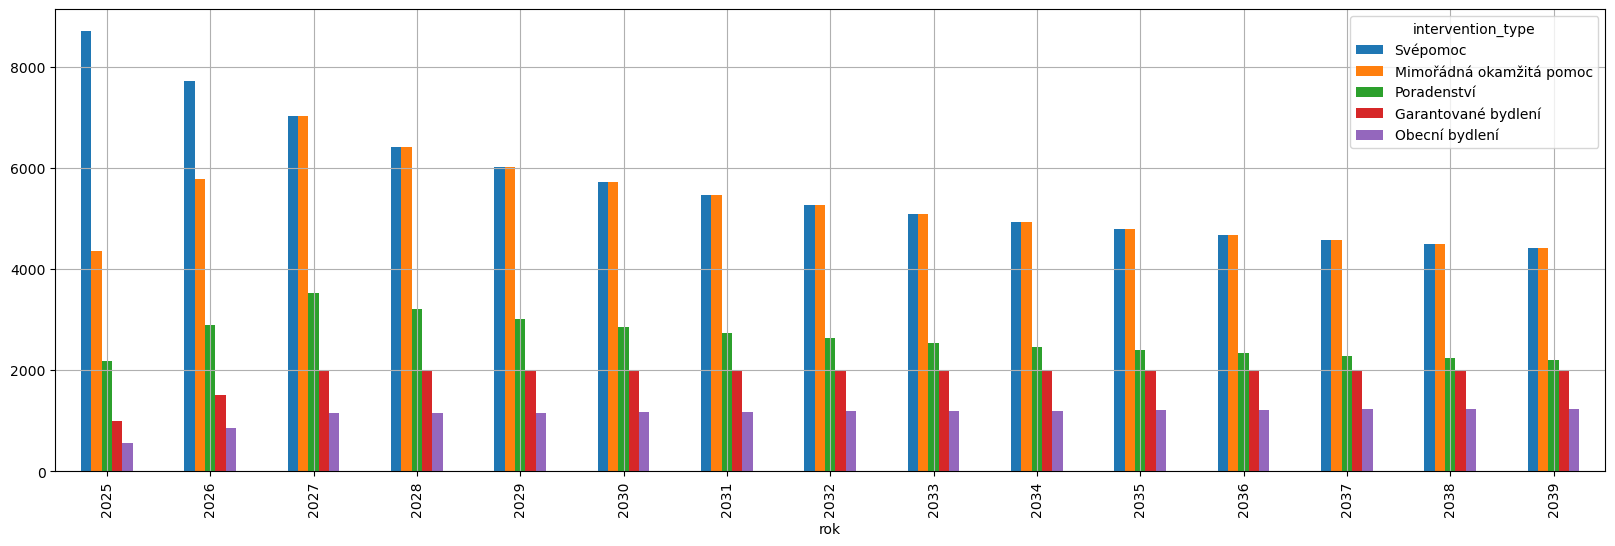

In [40]:
colmap = {
        'self_help': 'Svépomoc',
        'mop_payment': 'Mimořádná okamžitá pomoc',
        'consulting': 'Poradenství',
        'guaranteed': 'Garantované bydlení',
        'municipal': 'Obecní bydlení',
    }

OUTPUT_1A['interventions'][colmap.keys()].stack('intervention_type').sum(axis=1).unstack('intervention_type').rename(colmap,axis=1)[colmap.values()].plot.bar(figsize=(20,6),grid=True)

#### Graf Domácnosti s asistencí v bydlení dle typu intervence

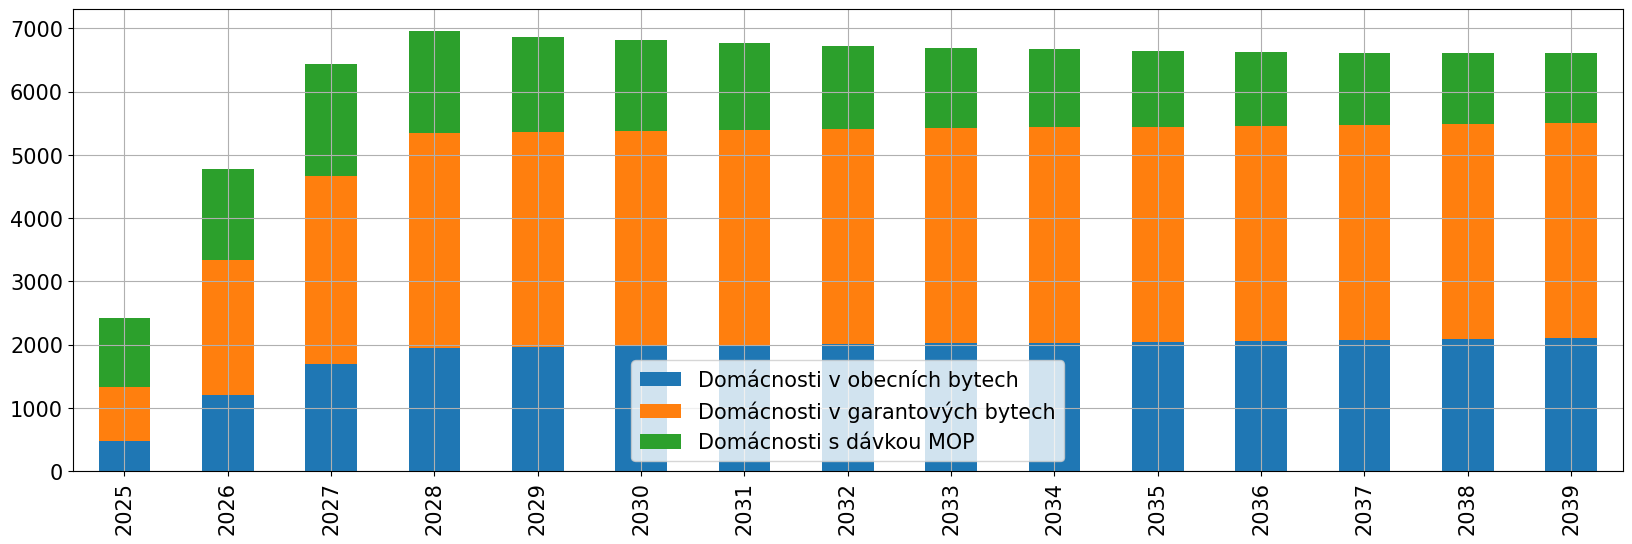

In [41]:
social = OUTPUT_1A['social_assistence_breakdown'][['municipal','guaranteed','mop_payment']].rename({
    'guaranteed':'Domácnosti v garantových bytech',
    'municipal':'Domácnosti v obecních bytech',
    'mop_payment':'Domácnosti s dávkou MOP'
},axis=1)
ax = social.plot.bar(stacked=True,figsize=(20,6),grid=True, title='', fontsize=15,xlabel='')
ax.legend(fontsize=15, loc='lower center');

#### Graf Náklady vynaložené na nástroje řešení bytové nouze

<Axes: title={'center': '1A: Mix opatření'}, xlabel='rok'>

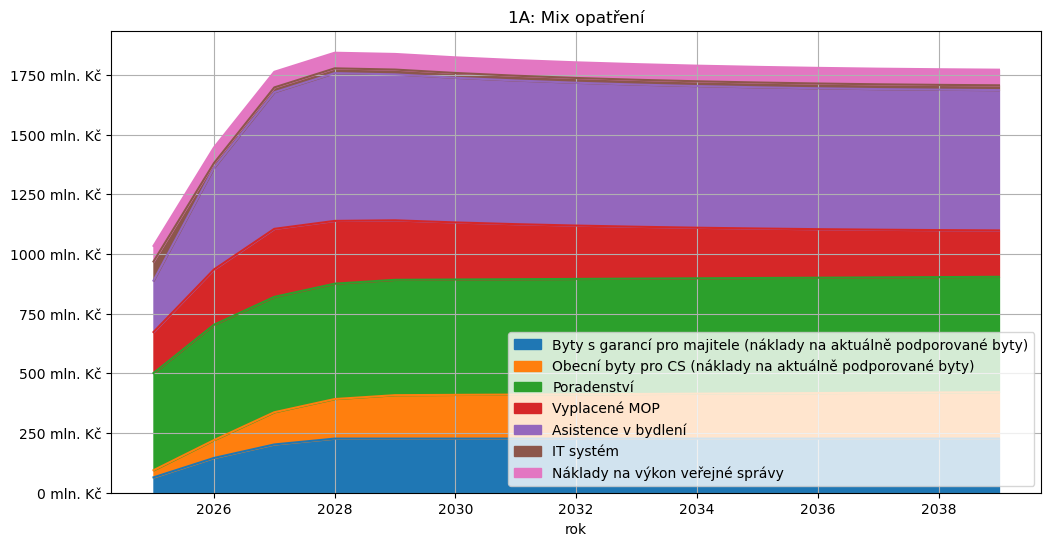

In [64]:
plot_interventions_costs(OUTPUT_1A)

#### Graf Náklady vč. rozpočtových nákladů bytové nouze

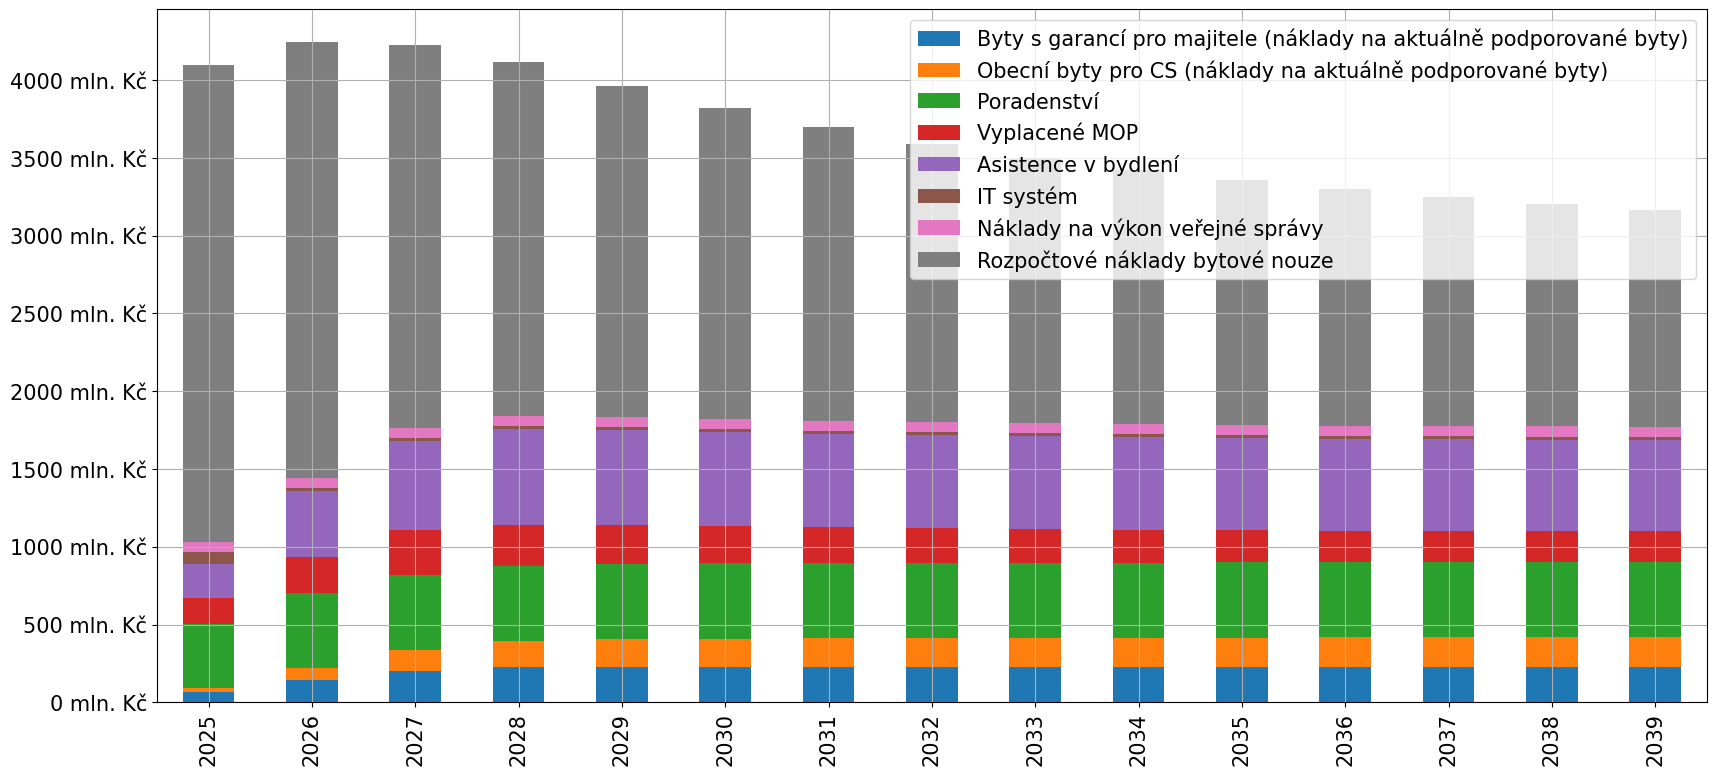

In [112]:
explicit_costs = get_intervention_costs(OUTPUT_1A,costs_type='costs')
explicit_costs['Rozpočtové náklady bytové nouze'] = OUTPUT_1A['costs'].queue_budget
ax = explicit_costs.plot.bar(stacked=True,figsize=(20,9),grid=True,fontsize=15)
ax.yaxis.set_major_formatter(MLN_FORMATTER)
ax.legend(fontsize=15)
ax.set_xlabel('');

### Výpočty pro text v ZZ RIA
#### Podíl opatření

In [102]:
interventions = OUTPUT_1A['interventions'].groupby('intervention_type',axis=1).sum()
interventions.div(interventions.sum(axis=1),axis=0)

intervention_type,consulting,guaranteed,mop_payment,municipal,self_help
rok,,,,,
2025,0.129532,0.059487,0.259064,0.033788,0.518129
2026,0.154330,0.080016,0.308660,0.045449,0.411546
2027,0.169684,0.096426,0.339367,0.055156,0.339367
2028,0.167117,0.104292,0.334234,0.060124,0.334234
2029,0.165269,0.109909,0.330538,0.063747,0.330538
2030,0.163720,0.114484,0.327440,0.066916,0.327440
2031,0.162340,0.118578,0.324679,0.069724,0.324679
2032,0.161061,0.122296,0.322122,0.072399,0.322122
2033,0.159870,0.125681,0.319740,0.074969,0.319740


In [101]:
interventions.sum()/interventions.sum().sum()

intervention_type
consulting     0.158521
guaranteed     0.114316
mop_payment    0.317043
municipal      0.067872
self_help      0.342248
dtype: float64

#### Podíly nákladů

In [122]:
explicit_costs = get_intervention_costs(OUTPUT_1A,costs_type='costs')

explicit_costs.div(explicit_costs.sum(axis=1),axis=0)

,Byty s garancí pro majitele (náklady na aktuálně podporované byty),Obecní byty pro CS (náklady na aktuálně podporované byty),Poradenství,Vyplacené MOP,Asistence v bydlení,IT systém,Náklady na výkon veřejné správy
rok,,,,,,,
2025,0.062224,0.028910,0.393621,0.166126,0.208428,0.077389,0.063302
2026,0.100656,0.051696,0.334247,0.160098,0.294187,0.013838,0.045278
2027,0.114672,0.076535,0.274056,0.161630,0.324637,0.011346,0.037124
2028,0.122993,0.089921,0.262170,0.142710,0.335838,0.010854,0.035514
2029,0.123335,0.098990,0.262900,0.135626,0.332652,0.010884,0.035613
2030,0.124296,0.100483,0.264949,0.131096,0.332315,0.010969,0.035891
2031,0.125082,0.101787,0.266624,0.127262,0.332088,0.011039,0.036117
2032,0.125736,0.103019,0.268017,0.123944,0.331881,0.011096,0.036306
2033,0.126269,0.104159,0.269153,0.121039,0.331776,0.011143,0.036460


In [124]:
explicit_costs/1000000

,Byty s garancí pro majitele (náklady na aktuálně podporované byty),Obecní byty pro CS (náklady na aktuálně podporované byty),Poradenství,Vyplacené MOP,Asistence v bydlení,IT systém,Náklady na výkon veřejné správy
rok,,,,,,,
2025,64.3230,29.885888,406.901511,171.731014,215.459833,80.0,65.43821
2026,145.4745,74.714720,483.074298,231.383085,425.176960,20.0,65.43821
2027,202.1310,134.907424,483.074298,284.903246,572.233429,20.0,65.43821
2028,226.6260,165.687784,483.074298,262.956917,618.814840,20.0,65.43821
2029,226.6260,181.893512,483.074298,249.210855,611.242186,20.0,65.43821
2030,226.6260,183.208912,483.074298,239.024647,605.901612,20.0,65.43821
2031,226.6260,184.419080,483.074298,230.574756,601.682827,20.0,65.43821
2032,226.6260,185.681864,483.074298,223.397706,598.183334,20.0,65.43821
2033,226.6260,186.944648,483.074298,217.240868,595.470041,20.0,65.43821


#### Srovnání s variantou 1B

In [127]:
costs_1b = get_intervention_costs(OUTPUT_1B,costs_type='costs')
costs_1b

,Byty s garancí pro majitele (náklady na aktuálně podporované byty),Obecní byty pro CS (náklady na aktuálně podporované byty),Poradenství,Vyplacené MOP,Asistence v bydlení,IT systém,Náklady na výkon veřejné správy
rok,,,,,,,
2025,128646000.0,46617776.0,406901511.0,1.860975e+08,3.151396e+08,80000000.0,65438210.0
2026,290949000.0,116597056.0,483074298.0,2.481610e+08,6.714192e+08,20000000.0,65438210.0
2027,404262000.0,210674464.0,483074298.0,3.002050e+08,9.131989e+08,20000000.0,65438210.0
2028,453252000.0,259028568.0,483074298.0,2.917582e+08,1.005967e+09,20000000.0,65438210.0
2029,453252000.0,284863024.0,483074298.0,2.761535e+08,9.972319e+08,20000000.0,65438210.0
2030,453252000.0,287441208.0,483074298.0,2.630306e+08,9.909514e+08,20000000.0,65438210.0
2031,453252000.0,289966776.0,483074298.0,2.515800e+08,9.859193e+08,20000000.0,65438210.0
2032,453252000.0,292439728.0,483074298.0,2.416513e+08,9.818058e+08,20000000.0,65438210.0
2033,453252000.0,294965296.0,483074298.0,2.330963e+08,9.786190e+08,20000000.0,65438210.0


<Axes: title={'center': '1B: Mix opatření - 2x více bytů'}, xlabel='rok'>

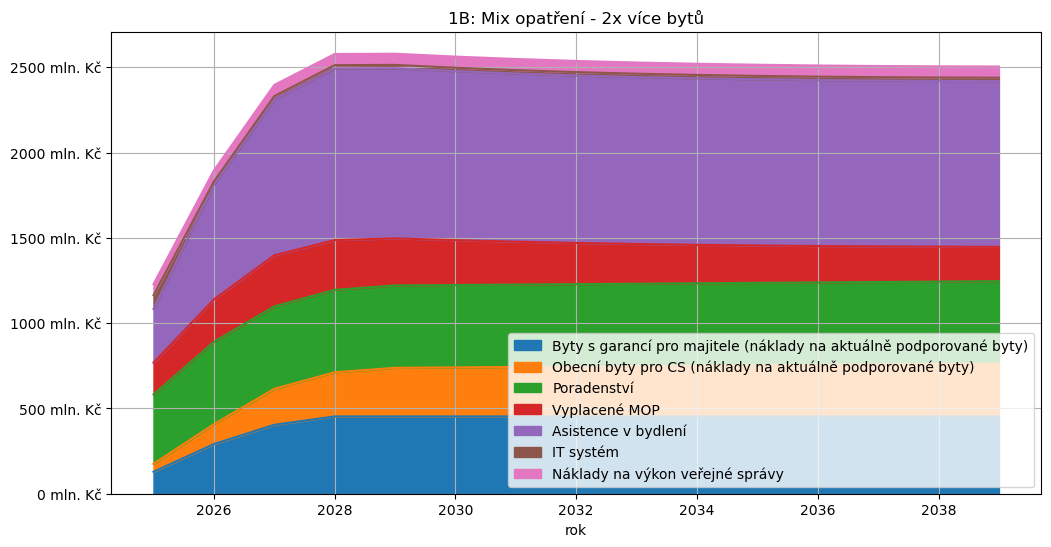

In [129]:
plot_interventions_costs(OUTPUT_1B)